In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import P2_helpers as hlp

# 0. Preprocesse the raw data
### 0.1 Transform the data from the text file into a DataFrame
Simply by reading line by line the text file, changing each "paragraph" into an entry of the new DF.

In [ ]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
original_df = df.copy()
df.sample(3)


### 0.2 Handle inconsistent data
 - Replace entirely space field or empyt filed by Numpy NaN values. Please note that the value None in the Comment is preferred.
 - Handle the inconsistent "Date" format.
 - Convert the type of Year into integer.

In [ ]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN (the case for some Source, Date and Comment)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#handle NaN values in Comment for vectorization
df.Comment = df.Comment.replace(np.nan, None)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

# Convert Year to int
df['Year'] = df['Year'].astype(int)

df.sample(3)

### 0.3 Handle duplicate in the data
Please not that by manually checking the data we found that the number 6 discriminates perfectly between users with actual duplicates and users with only missing data or basic comments


In [ ]:
# Select users with a significant number of duplicates (by manually checking the data we found that 6 discriminate perfectly between users with actual duplicates and users with only missing data or basic comments)
users_with_duplicates = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].groupby('Target').size() >= 6
users_with_duplicates = users_with_duplicates[users_with_duplicates].index
duplicates = df[df.Target.isin(users_with_duplicates) & df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].sort_values(by=['Target', 'Source', 'Date'])
#Remove the data of to_remove from df
df = df.drop(duplicates.index)


# Deal with duplicates that have different results 
perc_vote = (duplicates.groupby(['Target', 'Year']).Vote.value_counts(normalize=True) * 100).unstack(level='Vote')
perc_vote['Result'] = perc_vote.apply(lambda x: 1 if x['1'] >= 70 else -1, axis=1, result_type='reduce')
# Replace results in duplicates with results in perc_vote
duplicates['Results'] = duplicates.apply(lambda x: perc_vote.loc[(x['Target'], x['Year'])]['Result'].astype(int), axis=1)


# Deal with duplicates that have different years
correct_year = pd.DataFrame({'Year': duplicates.Date.dt.year, 'Target': duplicates.Target})
# Replace nan values in Year with most common year for each Target (some Dates are missing)
correct_year.Year = correct_year.groupby('Target').Year.transform(lambda x: x.fillna(x.mode()[0]))
# Replace years in duplicates with years in correct_year
duplicates = duplicates.drop(columns='Year').join(correct_year.Year)

# Drop the duplicate rows 
duplicates.drop_duplicates(keep='first', inplace=True)
# Add the duplicates to df
df = pd.concat([df, duplicates]).sort_index()


# Deal with duplicates that have different Vote
double_vote = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull() & df.Date.notnull() & (df.Vote == '0')]
# Drop the double_vote rows
df.drop(double_vote.index, inplace=True)

df.sample(3)

### 0.4 Saving the DataFrame 

In [ ]:
#df.to_csv('wiki-RfA.csv')

# 1. Some global statistics and visualization
### 1.1 Basic description of the statistics

In [ ]:
stats = df.describe(include='all')
stats.loc['percentage_nan'] = (1 - stats.loc['count'] / len(df)) * 100
stats

### 1.2 Visualization

In [ ]:
categorical_cols = ['Source', 'Target']
value_cols = ['Vote', 'Results', 'Year']
all_cols = categorical_cols + value_cols
n_top = 20
fig, axes = plt.subplots(len(all_cols), 2, figsize=(10,4*len(all_cols)))
for i, col in enumerate(all_cols):
    ax1 = axes[(2*i) // 2, (2*i) % 2]
    ax2 = axes[(2*i+1) // 2, (2*i+1) % 2]
    data = df[~df[col].isna()]
    if col in categorical_cols:
        top_n = pd.Series(data[col].value_counts().iloc[:n_top])
        others = pd.Series(data[col].value_counts().iloc[n_top:].sum(), index=['Others'])
        value_counts = pd.concat([top_n, others])
        
    elif col in value_cols:
        value_counts = data[col].value_counts()
    
    value_counts = 100*value_counts/np.sum(value_counts)
    labels = value_counts.index.to_list()

    # Count plot
    chart = value_counts[value_counts.index != 'Others'].plot(kind='bar', ax=ax1) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize = 8)
    ax1.set_title('Histogram of the ' + col)
    ax1.set_ylabel('Percentage')
    
    # Pie chart
    wedges, texts, autotexts = ax2.pie(value_counts, labels = labels, autopct='%1.1f%%')
    threshold = 2
    for label, pct_label in zip(texts, autotexts):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')
    
    #if too much labels, don't show legend
    if len(labels) < 12:
        ax2.legend(bbox_to_anchor=(1.05, 1), fontsize = 8)
    ax2.set_title('Pie chart of the ' + col)

fig.tight_layout()    
plt.show()

# 2. Time series computation and visualization of the votes and election rounds
### 2.1 Create and describe the time series 
The voting_time series will give the time in minutes at which each vote was cast with respect to the first vote recorded for the same target. We will consider the first vote as the opening time of the polls. Thus for each target we will have a voting time of 0. We print the basic statistic of the time serie.

In [ ]:
voting_time = (df.groupby('Target').Date.apply(lambda x: x - x.min()).dt.total_seconds()/3600).rename('Voting_time')

# add voting time to df dataframe, merge on index
df_timeserie = df.join(voting_time.droplevel(0))

# Convert Vote, Results and Year to int
df_timeserie['Vote'] = df_timeserie['Vote'].astype(int)
df_timeserie['Results'] = df_timeserie['Results'].astype(int)
df_timeserie['Year'] = df_timeserie['Year'].astype(int)

# Plot basic statistics
df_timeserie['Voting_time'].describe().round(2)

### 2.2 Missing values

In [ ]:
# Targets where all voting times are NaN
nan_target = set(df_timeserie.Target.unique()) - set(df_timeserie[~df_timeserie['Voting_time'].isna()].Target.unique())
print('Number of target without time data:', len(nan_target), ', corresponding to', round(len(nan_target)/len(df_timeserie.Target.unique())*100, 2), '% of all targets')
print('Target without time data:', nan_target)

# Amount of NaN values in the voting time column
print('Number of NaN values in the voting time column:', df_timeserie['Voting_time'].isna().sum(), ', corresponding to', round(df_timeserie['Voting_time'].isna().sum()/len(df_timeserie)*100, 2), '% of all values')

Removing NaN values 

In [ ]:
df_timeserie = df_timeserie[~df_timeserie['Voting_time'].isna()]

### 2.3 Analysis : Distribution of the voting time
#### 2.3.1 Histograms
We first plot the histogram and to be able to see something on the plot we need to use a log-axis for the votinf values. In order to be able to use it we remove the single vote that occures at time 0 for each election.

Plot histogram of voting time without log axis for voting time axis


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_timeserie, x='Voting_time', kde=True, ax=ax, bins=100, stat='percent')
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

 Plot histogram of voting time with log axis for voting time axis


In [ ]:
# Remove the vote at time 0 minute, to plot the histogram of voting time
df_plot = df_timeserie[df_timeserie.Voting_time != 0]

fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time',kde=True, ax=ax, bins=100, stat='percent', log_scale=(True, False))
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

#### 2.3.2 Plot the density function

In [ ]:
# Ignore warnings for the following plot - change in layout
import warnings 
warnings.filterwarnings('ignore')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(11, rot=-.25, light=.7)
g = sns.FacetGrid(df_plot, row='Year', hue='Year', aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Voting_time', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, log_scale=(True, False))
g.map(sns.kdeplot, 'Voting_time', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)

g.map(label, 'Voting_time')

# Set figure properties
#g.fig.set_tight_layout(True)
g.fig.subplots_adjust(hspace=-.25)
g.fig.set_figwidth(10)
g.fig.set_figheight(10)
g.fig.suptitle('Density plot of voting time per year', fontsize=16, y=0.9)
g.fig.supylabel('Density', fontsize=14, x=0.1)
g.fig.supxlabel('Voting time (hours)', fontsize=14, y=0.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='', xlabel='')
g.despine(bottom=True, left=True)

plt.show()
sns.set_theme()

We can notice at the first glance that in 2003 the voting time distribution was quite different from the other years. Indeed, the voting times were much more spread out and shifted to the left. This is probably due to the fact that at the creation of election system, the rules were not yet well established so the behaviour of the voters was not very consistent. 

#### 2.3.3 Dealing with year 2003
We will start by checking if the 2003 data represents a significant part of the data. 

In [ ]:
proportion_2003 = df[df['Year'] == 2003].shape[0] / df.shape[0]
print(f'Proportion of 2003 data: {proportion_2003:.2%}')

Knowing that the amount of data for 2003 represents only 0.1% of the total data, we can consider that these data are negligible and we can remove them from the dataset. 

In [ ]:
df = df[df['Year'] != 2003]
#df.to_csv('wiki-RfA.csv')

df_timeserie = df_timeserie[df_timeserie['Year'] != 2003]
# Update the voting time of the df_timeserie dataframe
voting_time = (df_timeserie.groupby('Target').Date.apply(lambda x: x - x.min()).dt.total_seconds()/3600).rename('Voting_time')
df_timeserie = df_timeserie.drop(columns=['Voting_time']).join(voting_time.droplevel(0))

df_plot = df_timeserie[df_timeserie.Voting_time != 0]

#### 2.3.4 Time Interval between votes

The bimodal distribution we get when plotting on a log scale (2.3.2) was unexpected, thus we can look at the disribution of time intervals between votes to find an explanation to this phenomenon.

Frist we try to seperate votes into rounds using a manually craft waiting time between to votes to decide cut between two rounds. 

///
### A check
We choose the value of 72 hours, in other words 3 days. 
///

In [ ]:
# Separate the vote for a candidate by elections rounds
votes_gap = df_timeserie.groupby('Target').Voting_time.apply(lambda x: x.sort_values().diff())
votes_gap.describe()

Plots histogram of "voting gap" - 

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10), tight_layout=True)

log_shift = 0.01
votes_gap_plot = votes_gap.dropna() + log_shift

sns.histplot(data=votes_gap_plot, ax=ax[0,0], stat='probability', bins=100, log_scale=(True, False))
ax[0,0].set_title('Histogram of voting gap on a log axis')
ax[0,0].set_xlabel('Voting gap (hours)')
ax[0,0].set_ylabel('Probability of votes')
ax[0,0].tick_params(bottom=True, left=True)
ax[0,0].set_xlim(0, np.max(votes_gap))
ticks = np.power(10, np.arange(np.log10(log_shift), np.ceil(np.log10(np.max(votes_gap_plot))), 1))
labels = [f'{tick:.0e}' for tick in ticks]
labels[0] = '0'
ax[0,0].set_xticks(ticks, labels=labels)

# Violin plot of voting gap
sns.violinplot(data=votes_gap_plot, ax=ax[0,1], orient='h', bw=0.2, cut=0, log_scale=(True, False), split=True, inner_kws=dict(box_width=10, whis_width=2, color="lightsteelblue"))
ax[0,1].set_title('Violin plot of voting gap')
ax[0,1].set_xlabel('Voting gap (hours)')
ax[0,1].set_ylabel('Density of votes')
ax[0,1].tick_params(bottom=True, left=True)
ax[0,1].set_xticks(ticks, labels=labels)

sns.histplot(data=votes_gap, ax=ax[1,0], stat='probability', bins=100, binrange=(0,20))
ax[1,0].set_title('Histogram of voting gap, close up on the small and most frequent values')
ax[1,0].set_xlabel('Voting gap (hours)')
ax[1,0].set_ylabel('Probability of votes')
ax[1,0].set_xlim(0, 20)
ax[1,0].tick_params(bottom=True, left=True)


sns.histplot(data=votes_gap, ax=ax[1,1], stat='probability', bins=100, log_scale=(True, False))
ax[1,1].set_title('Histogram of voting gap, close up on the extreme and rare values, logscale')
ax[1,1].set_xlabel('Voting gap (hours)')
ax[1,1].set_ylabel('Probability of votes')
ax[1,1].set_xlim(20, np.max(votes_gap))
ax[1,1].set_ylim(0, 0.01)
ax[1,1].set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], labels=['20', '50', '100', '200', '500', '1000', '2000', '5000', '10000', '20000', '50000']) 
ax[1,1].tick_params(bottom=True, left=True)

plt.show()

In [ ]:
print(f'Extract the voting gap corresponding to the 99% quantile: {votes_gap.quantile(0.99):.2f} hours')

We can see that the distribution of the time interval between votes almost follows an exponential distribution (which is what we would expect for this type of data). However, we can see that there is an additional very small peak between 1000 and 20000 hours, which reveals the presence of multiple batches/aggregate of votes separated by a long period of time. 

We interpret this as different rounds of elections. Indeed, some target are not elected at the first try and they run for admin again after a certain period of time. We now want to separate the data into different rounds of elections for each target.

#### 2.3.5 Separate data into rounds of elections


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time', kde=True, ax=ax, bins=100, stat='percent', log_scale=(True, False))
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

# Close up the voting time to 100-500 hours
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_plot, x='Voting_time', ax=ax, bins=100, stat='count', log_scale=(False, False), binrange=(150, 750), hue='Year', palette='tab10', multiple='stack')
ax.set_title('Histogram of voting time, zoomed in 100-500 hours and stacked by year')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Number of votes')
ax.set_xlim(150, 750)
plt.show()

# Fin the local minima
kde = kde.get_lines()[0].get_data()
deriv_kde_sign = np.sign(np.diff(kde[1]))
local_mins = kde[0][np.append((np.roll(deriv_kde_sign, 1) - deriv_kde_sign) != 0, False)]
y_mins = kde[1][np.append((np.roll(deriv_kde_sign, 1) - deriv_kde_sign) != 0, False)]

# only keep the minima with a y value < 0.1 and a x value is between 10 and 1e4
round_threshold = local_mins[(y_mins < 0.1) & (local_mins > 10) & (local_mins < 1e3)][0]
percent_at_threshold = y_mins[(y_mins < 0.1) & (local_mins > 10) & (local_mins < 1e3)][0]

print(f'After this threshold in hours, we consider that the incoming votes are part of a new election: {round_threshold:.2f} hours')
print(f'Percentage of votes happening at this threshold: {percent_at_threshold:.2}%')

To separate the different rounds of elections we focus on the gap between the 2 peaks in the distribution of voting time. First, we can observe that there is a huge drop in the amount of votes at around 170h which is consistent with the information we found on the Wikipedia page about the election duration being approximately 7 days (noting that this period can be prolonged in some cases). 

To find the best threshold to separate the data, we extracted the kernel density estimation of the distribution of voting time and we computed its local minimum in the gap between the 2 peaks and the corresponding voting time. We found that the best threshold to separate the data is 391h. We can now separate the data into different rounds of elections for each target using this threshold.

In [ ]:
rounds = (df_timeserie.groupby('Target').apply(lambda x: hlp.compute_rounds(x, round_threshold))).rename('Round')
df_timeserie = df_timeserie.join(rounds.droplevel(0))
df_timeserie.sample(3)

#### 2.3.6 Updating the voting time with respect to election rounds

In [ ]:
# Use the round number to compute the voting time in each round (i.e. the time between the current vote and the first vote of the round)
Voting_time_round = df_timeserie.groupby(['Target', 'Round']).Voting_time.apply(lambda x: x - x.min())
# Replace the column Voting_time by the voting time in each round
df_timeserie = df_timeserie.drop(columns='Voting_time').join(Voting_time_round.droplevel([0,1]))
df_plot = df_timeserie[df_timeserie.Voting_time != 0]
df_timeserie.sample(3)

Ploting the histogram of voting time

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time', ax=ax, bins=100, stat='percent', log_scale=(True, False), hue='Year', palette='tab10', multiple='stack')
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time in the round (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

In [ ]:
#df_timeserie.to_csv('wiki-RfA_timeserie.csv')

### 2.4 Votes evolution through time - explication nécessaire @Emma
We now focus on the study of statistics from votes. We first compute the progressive mean of the votes (the votes themselves ?).
 

In [ ]:
#saving previous work.
df_vote_evolution = df_timeserie.copy()

progressive_mean = df_vote_evolution.groupby(['Target', 'Round']).apply(lambda x: x.Vote.cumsum() / np.arange(1, len(x)+1)).rename('progressive_mean')

# Replace the column Vote by the progressive mean
df_vote_evolution = df_vote_evolution.join(progressive_mean.droplevel([0,1]))
df_vote_evolution.sample(3)

Convert the voting time into time deltas.

In [ ]:
df_vote_evolution.Voting_time = pd.to_timedelta(df_vote_evolution.Voting_time, unit='h')
df_vote_evolution.sort_values('Voting_time', inplace=True)
display(df_vote_evolution.sample(3))

In [ ]:
rolling_avg = df_vote_evolution.groupby('Results').rolling('1h', on='Voting_time').progressive_mean.aggregate(['mean', 'std']).reset_index(level='Voting_time')
rolling_avg.Voting_time = rolling_avg.Voting_time.dt.total_seconds()/3600
display(rolling_avg.sample(3))

Plot the evolution of the progressive mean of the votes in each round given rolling average.

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rolling_avg.loc[-1].Voting_time, rolling_avg.loc[-1]['mean'], label='Not elected')
ax.fill_between(rolling_avg.loc[-1].Voting_time, rolling_avg.loc[-1]['mean']-rolling_avg.loc[-1]['std'], rolling_avg.loc[-1]['mean']+rolling_avg.loc[-1]['std'], alpha=0.4)
ax.plot(rolling_avg.loc[1].Voting_time, rolling_avg.loc[1]['mean'], label='Elected')
ax.fill_between(rolling_avg.loc[1].Voting_time, rolling_avg.loc[1]['mean']-rolling_avg.loc[1]['std'], rolling_avg.loc[1]['mean']+rolling_avg.loc[1]['std'], alpha=0.4)
ax.set_title('Evolution of the progressive mean of the votes in each round')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Progressive mean of the votes')
ax.set_xlim(0, 24*7)
ax.set_ylim(-1, 1.3)
ax.legend(loc='lower right')
plt.show()  

In [ ]:
df_vote_evolution.groupby('Results')[['progressive_mean']].agg(['mean', 'std'])

# 3. Dive into on the Sources
### 3.1 Distribution of the source voting

In [ ]:
df_source = df.copy(deep=True)
#Artifact from the merge of code but for this part we need to interpret the Vote as integer
df_source.Vote = df_source.Vote.astype(int)

First we get a glance at the proportion of distinct source by year in comparison with the total number of sources overall.

In [ ]:
# Calculate the distribution of the source over the year
source_percentage = df_source.groupby('Year')['Source'].nunique() / len(df_source.Source.unique())*100

# Plotting
source_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of unique Source Voting Each Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

For each year we consider we take the average of the percentage of unique source that vote for a target. It gives us an indicator of the proportion of source participating in average. 

In [ ]:
d={}
year_index = range(2004, 2014)
for i in year_index:
  df_sub = hlp.select_year(df_source, i)
  nb_source =  len(df_sub.Source.unique())
  percent_by_target = df_sub.groupby('Target')['Source'].nunique()/nb_source*100
  d.update({i:percent_by_target.mean()})

election_source_percentage = pd.Series(data=d, index=year_index)

election_source_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average percentage of voting source for each election by year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

To have a "baseline" for the distribution of all votes we plot the count of votes for each year.

In [ ]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', hue='Vote', data=df_source)
plt.title('Distribution of Votes by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Vote', loc='upper right', labels=['-1', '0', '1'])
plt.show()

We can see that the trends of the proportion of different sources voting for at least one election by year and the average proportion of different soucres voting for specific vote is inversed.

On the other hand we can see that the proportion of different sources voting for at least one election is follwing the number of votes which seems fair. 

# 4. Community Extraction of Sources based on similar vote for Targets
We will use Louvain and Leiden algorithm, the second one beeing an improvement of the first: https://www.nature.com/articles/s41598-019-41695-z.

More on the implementation here: https://readthedocs.org/projects/leidenalg/downloads/pdf/latest/


In the first two subparts below we consider the Graph composed of:
 - Sources and Targets as Vertices
 - Vote of the given type as (undirected) Edges - for each algorithm we consider each type of vote (-1,0,1) in seperated Graph

Also please note that in this part we did not discareded the 2003 year yet. If in the following of this project, it relevant to do so we will do it.

In [ ]:
import igraph as ig 
import leidenalg as la

### 4.1 Louvain Algorithm
Communities creation.

In [ ]:
#Create a new DataFrame to hold the community data
columns = ['Year', 'Vote', 'Total nbr of community', 'Size of each community', 'Community members']
df_community=pd.DataFrame(columns=columns)

wiki_RfA_df = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Extracts the community of a given year and vote
years=wiki_RfA_df['Year'].unique()
for n, year in enumerate(years):
    G_community_pos = hlp.extract_community_louvain(wiki_RfA_df, year,1)
    size_communities_pos = hlp.compute_com_size(G_community_pos)
    df_community.loc[3*n] = [year, 1, len(size_communities_pos), size_communities_pos, G_community_pos]
    
    G_community_neg = hlp.extract_community_louvain(wiki_RfA_df, year,-1)
    size_communities_neg = hlp.compute_com_size(G_community_neg)
    df_community.loc[3*n+1] = [year, -1, len(size_communities_neg), size_communities_neg, G_community_neg]
    
    G_community_neu = hlp.extract_community_louvain(wiki_RfA_df, year,0)
    size_communities_neu = hlp.compute_com_size(G_community_neu)
    df_community.loc[3*n+2] = [year, 0, len(size_communities_neu), size_communities_neu, G_community_neu]

df_community.sample(3)


Plots the number of community per year and type of vote.

In [ ]:
sns.barplot(data=df_community[['Year', 'Vote', 'Total nbr of community']], x='Year', y='Total nbr of community', hue='Vote')

sns.set(rc={'figure.figsize':(10, 6)})
plt.title('Number of community per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Number of community')
plt.show()

### 4.2 Leiden Algorithm
Communities creation

In [ ]:
columns_ = ['Year', 'Vote', 'Total nbr of community', 'Size of each community']
df_community_leiden=pd.DataFrame(columns=columns_)

years=wiki_RfA_df['Year'].unique()
for n, year in enumerate(years):
    partition_pos = hlp.extract_community_leiden(wiki_RfA_df, year,1)
    features_pos = hlp.compute_partition_features(partition_pos)
    df_community_leiden.loc[3*n] = [year, 1, features_pos[0], features_pos[1]]

    partition_neg = hlp.extract_community_leiden(wiki_RfA_df, year,-1)
    features_neg = hlp.compute_partition_features(partition_neg)
    df_community_leiden.loc[3*n+1] = [year, -1, features_neg[0], features_neg[1]]

    partition_neu = hlp.extract_community_leiden(wiki_RfA_df, year,0)
    features_neu = hlp.compute_partition_features(partition_neu)
    df_community_leiden.loc[3*n+2]=[year, 0, features_neu[0], features_neu[1]]

df_community_leiden.sample(3)

Plots the number of community per year and type of vote.

In [ ]:
sns.barplot(data=df_community_leiden[['Year', 'Vote', 'Total nbr of community']], x='Year', y='Total nbr of community', hue='Vote')

plt.title('Number of community per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Number of community')
plt.show()

### 4.3 Leiden Algorithm with Directed Graph


# 5. Comments Analysis
### 5.1 Information Extractions from Comments

The mwparserfromhell librabry will be used for the parsing of WikiText from the comments.

In [3]:
import mwparserfromhell
from sklearn.feature_extraction.text import CountVectorizer

As in the previous part we will start over with less processed dataset.

In [ ]:
df_comment = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Parse the comments to a new column
df_comment['Comment'] = df_comment['Comment'].apply(lambda x: [] if pd.isna(x) else x)
df_comment["Parsed_Comment"] = df_comment.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

#Initialize a dataframe containing only relevant info for futur comment analysis
stat_df = pd.DataFrame(columns = ['Source','Vote', 'Comment', 'Parsed_Comment'])
stat_df['Vote']=df_comment['Vote']
stat_df['Source']=df_comment['Source']
stat_df['Comment'] = df_comment['Comment']
stat_df['Parsed_Comment']=df_comment['Parsed_Comment']

Count the number of word occurrences without taking into account "stopwords" (the, and, me...) from the comment language: english.


In [ ]:
vectorizer = CountVectorizer(stop_words='english')
stat_df['Vectorized_Comment'] = stat_df['Parsed_Comment'].apply(lambda x: vectorizer.build_analyzer()(x)) 
stat_df['Vector_Size'] = stat_df['Vectorized_Comment'].apply(lambda x: len(x))
stat_df.sample(3)

### 5.2 Some Statistics about Comments

In [ ]:
print(f'The minimum length of the comment is: {np.min(stat_df["Vector_Size"]):.2f}')
print(f'The maximum length of the comment is: {np.max(stat_df["Vector_Size"]):.2f}')

proportion_no_comment=np.sum(stat_df['Vector_Size']==0)/len(stat_df['Vector_Size'])*100
print(f'The percentage of vote without comment is: {proportion_no_comment:.2f}%')
proportion_one_word=np.sum(stat_df['Vector_Size']==1)/len(stat_df['Vector_Size'])*100
print(f'The percentage of comment with one word is: {proportion_one_word:.2f}%')
proportion_two_word=np.sum(stat_df['Vector_Size']==2)/len(stat_df['Vector_Size'])*100
print(f'The percentage of comment with 2 words is: {proportion_two_word:.2f}%')

#### 5.2.1 Vote without comments

In [ ]:
zero_word = stat_df[stat_df['Vector_Size']==0] #the vectorization removes almost all stop words/non significant words
zero_word.sample(3)

We want to see if there is a specific tendency in the vote (support, opposition or neutral). We could consider that votes without comments are obvious votes subject to less controversy and therefore we could expect to have a large proportion of positive votes.

In [ ]:
dist_vote_no_comment= zero_word['Vote'].value_counts(normalize=True)*100
sns.barplot(x=dist_vote_no_comment.index, y=dist_vote_no_comment.values)
plt.title('Distribution (percentage) of vote for vote without comment')
plt.show()

Indeed we obtain a large majority of positive vote.

#### 5.2.2 Vote with one comment
We conduct the same analysis as for no-comment vote.

In [ ]:
one_word = stat_df[stat_df['Vector_Size']==1]

print(f"Proportion of comment of one word {len(one_word['Vector_Size'])/len(stat_df['Vector_Size'])*100:.2f}%")

As for vote without any comment, we could expect that votes with one word comment are straightforward votes and then we can expect a similar trend to votes without comments

In [ ]:
dist_vote_one_word_comment= one_word['Vote'].value_counts(normalize=True)*100
sns.barplot(x=dist_vote_one_word_comment.index, y=dist_vote_one_word_comment.values)
plt.title('Distribution (percentage) of vote for vote with one word comment')
plt.show()

In [ ]:
df_one_word = pd.DataFrame(np.concatenate(one_word['Vectorized_Comment'].values), columns=['word']) #handle the list of string type for each row
percentage=df_one_word['word'].value_counts(normalize=True)*100
print('Percentage of the 15 first one word comment:')
percentage[:15]

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage[:15].index, y=percentage[:15].values)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Word occurrence')
plt.ylabel('Percentage (%)')
plt.title('Percentage of word occurrence of the 15 first words (in 1 word comment)')
plt.show()

#### 5.2.3 Vote with two comments
We conduct the same analysis as for no-comment and one comment votes.

In [ ]:
two_words = stat_df[stat_df['Vector_Size']==2]

First we look at word independtly, it means that for each comment we consider that the 2 words are not related

In [ ]:
#Look at words individually
df_two_words = pd.DataFrame(np.concatenate(two_words['Vectorized_Comment'].values), columns=['word']) 
percentage_2words_ind=df_two_words['word'].value_counts(normalize=True)*100
print('Percentage of the 15 first words when looking at 2 word comment and considering each word independetly')
percentage_2words_ind[:15]

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_2words_ind[:15].index, y=percentage_2words_ind[:15].values)
plt.xticks(rotation=45)
#plt.yscale('log')
plt.xlabel('Word occurrence')
plt.ylabel('Percentage')
plt.title('Percentage of occurrence of the 15 first words (in 2 word comment)')
plt.show()

Since taking word independently does not allow to take into account the context, we look at comment with the 2 words together. 

In [ ]:
#Look at pair of word
#order word to be able to compare them
df_paired_2words = pd.DataFrame(two_words['Vectorized_Comment'].values, columns=['word'])
df_paired_2words['word'] = df_paired_2words['word'].apply(lambda x: sorted(x))

paired_2words_percentage=df_paired_2words['word'].value_counts(normalize=True)*100
print('Percentage of the 15 first pair of words when looking at 2 word comment')
paired_2words_percentage[:15]

In [ ]:
#convert values of x axis with the correct type for the plot
paired_strings = [' + '.join(pair) for pair in paired_2words_percentage.index]

plt.figure(figsize=(12, 6))
sns.barplot(x=paired_strings[:15], y=paired_2words_percentage[:15].values)
plt.xticks(rotation=70)
#plt.yscale('log')
plt.xlabel('Word occurrence')
plt.ylabel('Percentage')
plt.title('Percentage of occurrence of the 15 first pair of words (in 2 word comment)')
plt.show()

Generally speaking, we can see that the word "Support" is dominant in all comments of size 1 or 2. The word "oppose" appears with a high proportion for comments of one word and 2 words treated independently, whereas this is not the case for the treatment of pairs of 2 words. We would expect to see the same pattern when all the words in the comments are taken into account.

#### 5.3.4 Most frequently used words (all comments)

Creates word array for all small dataframe

In [ ]:
#Split the dataframe to avoid memory problem (may not be necessary)
list_of_dataframes = np.array_split(stat_df, 100)

word_array=[]
tot_nbr_words=0
for n in range(len(list_of_dataframes)):
    df_comment=pd.DataFrame(np.concatenate(list_of_dataframes[n]['Vectorized_Comment'].values), columns=['word'])
    word_array.append(df_comment)
    tot_nbr_words += len(df_comment['word'])

Count the number of word for each occurence

In [ ]:
def compute_sum_word(df):
    return df['word'].value_counts()
count = list(map(compute_sum_word, word_array))

Merge result

In [ ]:
#concatenate all word-occurrence for all array
all_words_df = pd.concat(count, axis=1).T
#compute the percentage of occurrence for all words present in the comment
percentage_word = all_words_df.sum(axis=0)/tot_nbr_words*100
#order for the plot
ordered_percentage_word= percentage_word.sort_values(ascending=False)

Plots results

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x=ordered_percentage_word[:50].index, y=ordered_percentage_word[:50].values)
plt.xticks(rotation=70)
plt.xlabel('Word occurrence')
plt.ylabel('Percentage')
plt.title('Percentage of occurrence of the 50 first words in all comments')
plt.show()

As expected we have the words "support" and "oppose" as the most dominant word in all comments.

#### 5.3.5 Plots the result distribution

In [ ]:
sns.histplot(stat_df['Vector_Size'],binwidth=1, kde=False)  
plt.title('Comment lengths distribution')
plt.xlabel('Number of words per comment')
plt.ylabel('Number of comment')
plt.yscale('log')
plt.show()

In [ ]:
sns.histplot(data=stat_df, x='Vector_Size', kde=True, binwidth=1, stat='percent') 
plt.title('Percentage of word occurrences as a function of comment size (bin of 1 word)')
plt.show()

In [ ]:
sns.histplot(data=stat_df, x='Vector_Size', kde=True, binwidth=10, stat='percent') #j'ai pris arbitrairement 10 mots
plt.title('Percentage of word occurrences as a function of comment size (bin of 10 words)')
plt.show()

From here we call our best friend - the log - to save us, in order to see something.

In [ ]:
log_shift = 0.1
vector_size_plot = stat_df.Vector_Size + log_shift

fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=vector_size_plot, kde=True, stat='percent', log_scale=(True, False), bins=100, ax=ax) #j'ai pris 10 arbitrairement, à changer au besoin
ax.set_title('Comment length distribution (percentage)')
ax.set_xlabel('Number of word per comment')
ax.set_ylabel('Percentage of comment')
ax.set_xscale('log')
ticks = np.power(10, np.arange(np.log10(log_shift), np.ceil(np.log10(np.max(vector_size_plot))), 0.5))
labels = [f'{tick:.0e}' for tick in ticks]
labels[0] = '0'
labels[1] = ''
ax.set_xticks(ticks, labels=labels)
plt.show()

From these plots we can see that most comments have less than 30 words.

# 6. Extracting more Information about Comments

As in the previous part we will start over with less processed dataset. Moreover here we consider similarities Target-wise but we could also do the following analysis election-wise. 

In [4]:
df_cosine_similarity = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Parse the comments to a new column
df_cosine_similarity['Comment'] = df_cosine_similarity['Comment'].apply(lambda x: [] if pd.isna(x) else x)
df_cosine_similarity["Parsed_Comment"] = df_cosine_similarity.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

df_cosine_similarity.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Parsed_Comment
809,IRWolfie-,Legoktm,1,1,2013.0,2013-05-05 08:58:00,'''Support''' I was concerned with the opposes...,Support I was concerned with the opposes menti...
197408,Dbachmann,Nathanlarson32767,0,-1,2004.0,2004-12-27 11:40:00,agree that the account is too young for a self...,agree that the account is too young for a self...
56732,Aua,Cirt,1,1,2008.0,2008-09-09 14:01:00,"'''Support'''- Sure thing! Overdue, though. :)...","Support- Sure thing! Overdue, though. :) Cheer..."


### 6.1 Cosinus Similarity

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

#### 6.1.1 Extracts consine similarities
Groups by Target the DF, please note that we compute similarity between comments that are targetted to the same Target for performance reason and relevance too. But we computed the TF-IDF vectorization on the whole comment lists. 

In [6]:
#Group by Target
grouped_by_target = df_cosine_similarity.groupby('Target').apply(lambda x: list((enumerate(zip(x['Source'], x['Parsed_Comment'])))))
grouped_by_target = grouped_by_target.apply(lambda x: [(item[1][0], item[0], item[1][1]) for item in x]).reset_index()
grouped_by_target = grouped_by_target.rename(columns={0:'Text'})

#Build UID for all pairs of (SRC, Comment)
global_index = 0
for df_index, row in grouped_by_target.iterrows():
    length_of_current_list = len(row.Text)
    mrange = range(global_index, global_index+length_of_current_list)
    global_index += length_of_current_list
    new_list = [(item[0], idx, item[2]) for item, idx in zip(row.Text, mrange)]
    grouped_by_target.at[df_index, 'Text'] = new_list

#Format to have dictionary to be sure to access things in the right order
grouped_by_target.Text = grouped_by_target.Text.apply(lambda x: {(item[0], item[1]):item[2] for item in x})

#Extracting and flattening of the comments with UID 
comments_list = [row.Text for _, row in  grouped_by_target.iterrows()]
comments_dict = {}
for d in comments_list:
    comments_dict.update(d)

#Compute the tfidf coefficient building the vectors
tfidf_m_sparse = hlp.tf_idf_matrix(comments_dict)

#Reformat the output to be normaly indexable (no need to optimize with sparse matrix)
tfidf_m =  tfidf_m_sparse.todense()

#Match the tfidf vectors to corresponding vectors
grouped_by_target['tfidf_matrix'] = grouped_by_target.Text.apply(lambda x: tfidf_m[hlp.get_idx_lower_bound(x.keys()):hlp.get_idx_upper_bound(x.keys())+1])

#Compute the cosinus similarity
new_rows = []
for index_df, row in grouped_by_target.iterrows():
    target_tfidf_dense_matrix = np.asarray(row.tfidf_matrix)
    target_cos_sim = cosine_similarity(target_tfidf_dense_matrix, target_tfidf_dense_matrix)
    new_rows.append(target_cos_sim)
grouped_by_target["cosine_similarity"] = new_rows

#### 6.1.2 Get some basic statistics on Cosine Similarities

The cosine similarities are stored in one matrix for each target. This matrix is symmetrical and the digonal values are 1 - since a comment is fully similar to itself. So I transform this matrix into dictionnary with keys based on Unique Identifiers as define above.

In [7]:
grouped_by_target['cosine_similarity_by_paires'] = grouped_by_target.cosine_similarity.apply(hlp.generate_cossim_pairs)

Get the whole collection of cosine similarity values from dictionnaries.

In [9]:
collection_of_values = [value for subdic in grouped_by_target.cosine_similarity_by_paires for value in subdic.values()]
mean_cov = np.mean(collection_of_values)
std_cov = np.std(collection_of_values)
median_cov = np.median(collection_of_values)
top_5 = np.percentile(collection_of_values, 95)
top_10 = np.percentile(collection_of_values, 90)
top_15 = np.percentile(collection_of_values, 85)
top_20 = np.percentile(collection_of_values, 80)
top_25 = np.percentile(collection_of_values, 75)
top_1 = np.percentile(collection_of_values, 99)
top_2 = np.percentile(collection_of_values, 98)
top_3 = np.percentile(collection_of_values, 97)
top_4 = np.percentile(collection_of_values, 96)
print(f"Mean: {mean_cov}")
print(f"Std: {std_cov}")
print(f"Median: {median_cov}")

Mean: 0.04409480773994
Std: 0.1023223574767852
Median: 0.011119575994196301


Plots the histogram of cosinus similarity values

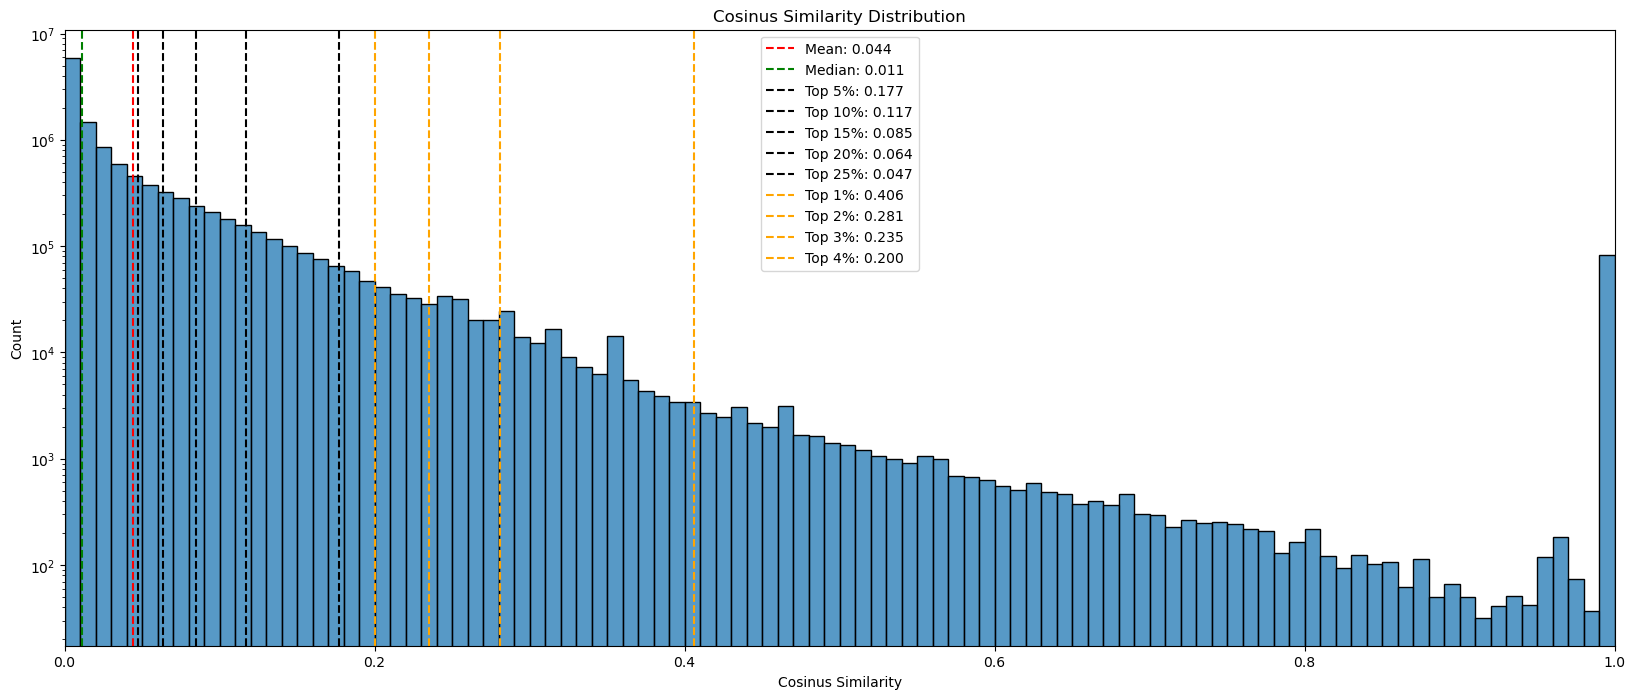

In [10]:
plt.figure(figsize=(20, 8))
sns.histplot(collection_of_values, bins=100, kde=False)

plt.yscale('log')
plt.xlim(0, 1)

plt.axvline(x=mean_cov, color='red', linestyle='--', label=f'Mean: {mean_cov:.3f}')
plt.axvline(x=median_cov, color='green', linestyle='--', label=f'Median: {median_cov:.3f}')

plt.axvline(x=top_5, color='black', linestyle='--', label=f'Top 5%: {top_5:.3f}')
plt.axvline(x=top_10, color='black', linestyle='--', label=f'Top 10%: {top_10:.3f}')
plt.axvline(x=top_15, color='black', linestyle='--', label=f'Top 15%: {top_15:.3f}')
plt.axvline(x=top_20, color='black', linestyle='--', label=f'Top 20%: {top_20:.3f}')
plt.axvline(x=top_25, color='black', linestyle='--', label=f'Top 25%: {top_25:.3f}')

plt.axvline(x=top_1, color='orange', linestyle='--', label=f'Top 1%: {top_1:.3f}')
plt.axvline(x=top_2, color='orange', linestyle='--', label=f'Top 2%: {top_2:.3f}')
plt.axvline(x=top_3, color='orange', linestyle='--', label=f'Top 3%: {top_3:.3f}')
plt.axvline(x=top_4, color='orange', linestyle='--', label=f'Top 4%: {top_4:.3f}')

plt.title("Cosinus Similarity Distribution")
plt.xlabel("Cosinus Similarity")
plt.ylabel("Count")

plt.legend()
plt.show()

We can see that an extremly large majority of the similarites are below 0.5 which can be great to discrimine between comments. But there is also a pick around and these comments are likely to be the shortest ones with "support" and "oppose" as main parts of them.

# Todo 
see if we add from source_alex the count of vote for each year